# CS440/ECE448 Spring 2024
# MP09: Transformer

The first thing you need to do is to download mp09.zip. Unlike several previous MPs, you will need to complete the code in several .py files

This file (`mp09_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

Throughout this MP, you will implement many of the operations in the Transformer architecture. The implementation will mostly follow the instructions in the original paper "Attention is All You Need" by Vaswani et al, 2017. (https://arxiv.org/abs/1706.03762). Much of the class structures and code have already been completed for you, and you are only required to fill in the missing parts as instructed by the comments in the code and in this notebook.

### Table of Contents
* [Code Structure](#chapter0)
* [Multi-head Attention](#chapter1)
* [Positional Encoding](#chapter2)
* [Transformer Encoder](#chapter3)
* [Transformer Decoder](#chapter4)
* [Extra Credit: Auto-regressive Decoding During Inference](#chapter5)


## Code structure <a class="anchor" id="chapter0"></a>

The repository, once unzipped, is structured like this: 

```
  ├─ data - Folder that contains either synthetic or real data and the expected outputs, for use by the tests. 
  │
  ├─ tests - Folder that contains tests used by grade.py
  │
  ├─ mha.py - Implements multi-head attention; you need to implement some part of it
  │
  ├─ pe.py - Implements positional encoding; you need to implement some part of it
  │
  ├─ encoder.py - Implements the Transformer encoder layer and the encoder; you need to implement some part of it
  │
  ├─ decoder.py - Implements the Transformer decoder layer and the decoder; you need to implement some part of it.
  │
  ├─ transformer.py - Implements the Transformer decoder layer and the decoder; you need to implement some part of it
  │
  ├─ grade.py - Launches some tests on the visible data and their expected output given to you
  │
  ├─ trained_de_en_state_dict.pt - A trained Transformer encoder-decoder checkpoint for checking your implementation.

```

We suggest that you create a new environment with Python 3.10 for this MP to avoid conflict with other versions of PyTorch and its dependencies that you might already have installed before in your current Python environment; if you use Anaconda, you can do this by

`conda create -n transformer_mp_torch_2.0.1 python=3.10`

`conda activate transformer_mp_torch_2.0.1`

Then, in this environment,

For OSX, run
`pip install torch==2.0.1`

For Linux and Windows, run
`pip install torch==2.0.1 --index-url https://download.pytorch.org/whl/cpu`

Then you can install the rest of the dependencies with

`pip install gradescope-utils`

`pip install editdistance`

`pip install numpy`

`pip install jupyterlab`

You can now re-open this notebook by launching `jupyter lab` in the newly created environment.

Note: for our provided visible test output to match yours, you must specify the PyTorch version of `torch==2.0.1`. Otherwise, local testing may show small discrepancies, such as if you use another version of PyTorch. The GradeScope auto-grader will NOT show any discrepancies as it shall be able to generate test outputs (on the hidden set) automatically.

## Multi-head Attention <a id="chapter1"></a>

The multi-head attention mechanism forms the backbone of Transformer encoder and decoder layers. The paper summarizes the operation of Multi-head attention as:
$$
\begin{aligned} \operatorname{MultiHead}(Q, K, V) & =\operatorname{Concat}\left(\operatorname{head}_1, \ldots, \text { head }_{\mathrm{h}}\right) W^O \\ \text { where head } & =\operatorname{Attention}\left(Q W_i^Q, K W_i^K, V W_i^V\right)\end{aligned}
$$

In essence, the multi-head attention module takes three inputs, the query matrix ($Q$), the key matrix ($K$), and the value matrix ($V$). $Q$, $K$, $V$ goes through $h$ different linear transformations, resulting in $QW_i^Q$, $K W_i^K$, $V W_i^V$ for $i \in \{1,\cdots h\}$. For simplicity, we will assume that $ Q \in \mathbb{R}^{T_q \times d_{model}}$, $ K \in \mathbb{R}^{T_k \times d_{model}}$,  $ V \in \mathbb{R}^{T_k \times d_{model}}$, $W_i^Q \in \mathbb{R}^{d_{model} \times d_{k}}$, $ W_i^K \in \mathbb{R}^{d_{model} \times d_{k}}$, $W_i^V \in \mathbb{R}^{d_{model} \times d_{k}}$ and $d_k \times h = d_{model}$. 

For each different set of $Q_i := QW_i^Q$, $ K_i := K W_i^K$, $ V_i := V W_i^V$, scaled-dot product attention is computed as:
$$\operatorname{Attention}(Q_i, K_i, V_i)=\operatorname{softmax}\left(\frac{Q_i K_i^T}{\sqrt{d_k}}\right) V_i$$
where $d_k$ is the dimension of the individual attention heads.

Finally, $\operatorname{Attention}(Q_i, K_i, V_i)$ from different heads $i$ are concatenated, and the concatenated result goes through another linear transformation $W^O \in \mathbb{R}^{d_{model} \times d_{model}}$.

The figure from pg.4 of the paper shows an illustration of the operations involved.

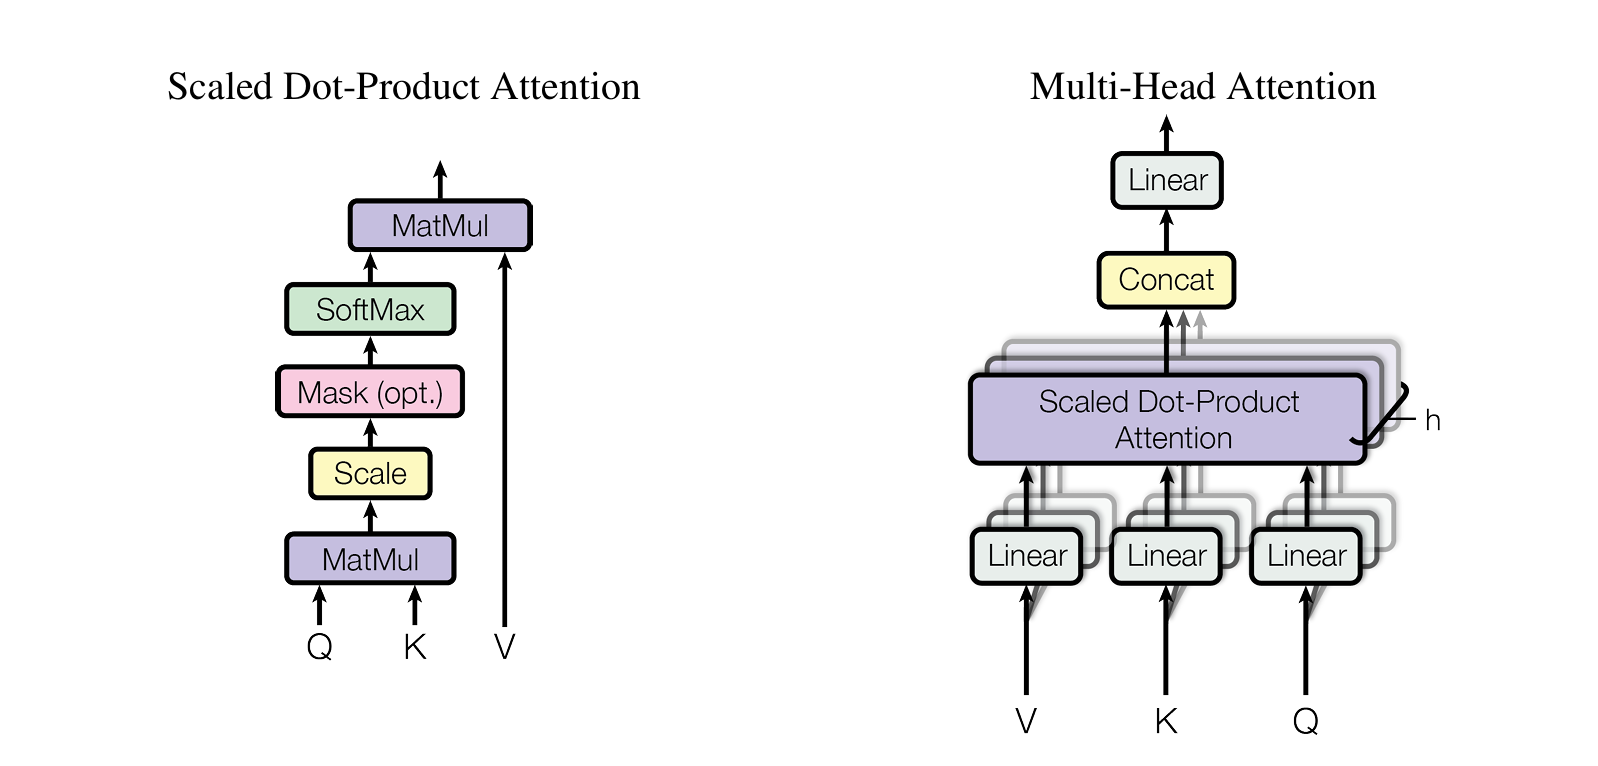

In [13]:
from IPython.display import Image
Image("img/mha.PNG")

In `mha.py`, you will need to implement two functions: `def compute_mh_qkv_transformation(self, Q, K, V)` and `def compute_scaled_dot_product_attention(self, query, key, value, key_padding_mask = None, attention_mask = None)` in the class `class MultiHeadAttention(nn.Module)`. They will be combined in `def forward(self, query, key, value, key_padding_mask = None, attention_mask = None)` to implement the entire operations involved in the multi-head attention mechanism. The model parameters, especially $W^Q$, $W^K$, $W^V$, and $W^O$, are defined and given in `def __init__(self, d_model, num_heads)`, and should not be modified. You should not import other helpers not already given to you.

Note: 
1. $W^Q$, $W^K$, and $W^V$ are not defined as separate `nn.Linear` objects in `class MultiHeadAttention(nn.Module)`.  In `def compute_mh_qkv_transformation(self, Q, K, V)`, you need to use `torch.Tensor.contiguous().view()` to reshape the last dimension from a single dimension of size `d_model` to two dimensions `num_heads x d_k` (hint: the reverse operation has been defined at the last line of `def compute_scaled_dot_product_attention(self, query, key, value, key_padding_mask = None, attention_mask = None)`, already given to you), and then use `torch.Tensor.transpose()` to get the expected output shape.
2. In `def compute_scaled_dot_product_attention(self, query, key, value, key_padding_mask = None, attention_mask = None)`, you will also need to correctly apply the masking operations. There are two different masks, the `key_padding_mask` and the `attention_mask`. Both are used to disallow attention to certain regions of the input. Please read the function definitions to figure out how to use them. 

In [1]:
from mha import MultiHeadAttention
help(MultiHeadAttention.compute_mh_qkv_transformation)

Help on function compute_mh_qkv_transformation in module mha:

compute_mh_qkv_transformation(self, Q, K, V)
    Transform query, key and value using W_q, W_k, W_v and split 
    
    Input:
        Q (torch.Tensor) - Query tensor of size B x T_q x d_model.
        K (torch.Tensor) - Key tensor of size B x T_k x d_model.
        V (torch.Tensor) - Value tensor of size B x T_v x d_model. Note that T_k = T_v.
    
    Output:
        q (torch.Tensor) - Transformed query tensor B x num_heads x T_q x d_k.
        k (torch.Tensor) - Transformed key tensor B x num_heads x T_k x d_k.
        v (torch.Tensor) - Transformed value tensor B x num_heads x T_v x d_k. Note that T_k = T_v
        Note that d_k * num_heads = d_model



In [15]:
help(MultiHeadAttention.compute_scaled_dot_product_attention)

Help on function compute_scaled_dot_product_attention in module mha:

compute_scaled_dot_product_attention(self, query, key, value, key_padding_mask=None, attention_mask=None)
    This function calculates softmax(Q K^T / sqrt(d_k))V for the attention heads; further, a key_padding_mask is given so that padded regions are not attended, and an attention_mask is provided so that we can disallow attention for some part of the sequence
    Input:
    query (torch.Tensor) - Query; torch tensor of size B x num_heads x T_q x d_k, where B is the batch size, T_q is the number of time steps of the query (aka the target sequence), num_head is the number of attention heads, and d_k is the feature dimension;
    
    key (torch.Tensor) - Key; torch tensor of size B x num_head x T_k x d_k, where in addition, T_k is the number of time steps of the key (aka the source sequence);
    
    value (torch.Tensor) - Value; torch tensor of size B x num_head x T_v x d_k; where in addition, T_v is the number of 

If you believe you have implemented it correctly, you can run python.grade.py to see if you have passed the tests related to `mha.py`. We have defined four tests (out of 10, including 2 for EC) that you should have passed: `test_mha_no_mask`, which tests the basic operation of  `mha.py` without masking involved, `test_mha_key_padding_mask`,  which, in addtion, tests `mha.py` with `key_padding_mask`, `test_mha_key_padding_mask_attention_mask`, which, in addtion, tests `mha.py` with `key_padding_mask` and `attention_mask`, and `test_mha_different_query_and_key`, which tests `mha.py` with query and key (value) of different length in the temporal dimension.

It is expected, for now, for the other six tests to either fail or error out.

In [20]:
!python grade.py

EEE....FEE
ERROR: test_encoder_decoder_predictions (test_visible.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\tests\test_visible.py", line 311, in test_encoder_decoder_predictions
    output = model(src = src, tgt = trg, src_lengths = src_lengths, tgt_lengths = trg_lengths)
  File "C:\Users\leebo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 227, in forward
    enc_output, src_padding_mask = self.forward_encoder(src, src_lengths)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 152, in forward_encoder
    src_embedded = self.dropout(self.positional_encod

## Positional Encoding <a id="chapter2"></a>

In order for the model to make use of the order of the sequence, some information about the relative or absolute position of the tokens in the sequence must be injected into the input embeddings at the bottoms of the encoder and decoder stacks. These positional encodings have the same dimension $d_{model}$ as the embeddings and the rest of the encoder and decoder modules. The original paper defines a simple positional encoding as sine and cosine functions of different frequencies:
$$
\begin{aligned}
P E_{(p o s, 2 i)} & =\sin \left(\operatorname{pos} / 10000^{2 i / d_{model}}\right) \\
P E_{(p o s, 2 i+1)} & =\cos \left(\operatorname{pos} / 10000^{2 i / d_{model}}\right)
\end{aligned}
$$
where $pos$ is the position and $i$ is an index into the dimension $d_{model}$ (i.e., $i \in \{0, 1, \cdots, d_{model}\}$). That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from $2\pi$ to $10000  \times 2 \pi$.

In `pe.py`, you will need to fill in the missing code to calculate the positional encoding, `self.pe`, in `def __init__(self, d_model, max_seq_length)` and implement the function `def forward(x)` in the class `class PositionalEncoding(nn.Module)`.

Note:
1. For better numerical accuracy, it is recommended that you make use of:
$$\frac{1}{10000} ^ {\frac{2i}{d_{model}}} = \exp ^ {2i  \times (-\frac{\log(10000)}{d_{model}})}$$
2. We assume that the input `x` in `def forward(x)` will always be smaller than the `max_seq_length`, so you can safely slice into `self.pe`

If you believe you have implemented everything in this section correctly, you can run `python.grade.py` to see if you have passed the test related to `pe.py`. We have defined one test for `pe.py` that you should have passed: `test_pe`, which initializes a `PositionalEncoding` object, test to see if you have filled in `self.pe` correctly, and if the `def forward(x)` works with some random test data.

It is expected, for now, for the other five tests to either fail or error out (assuming you passed the four tests for `mha.py` already)

In [26]:
!python grade.py

EEE.....EE
ERROR: test_encoder_decoder_predictions (test_visible.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\tests\test_visible.py", line 311, in test_encoder_decoder_predictions
    output = model(src = src, tgt = trg, src_lengths = src_lengths, tgt_lengths = trg_lengths)
  File "C:\Users\leebo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 227, in forward
    enc_output, src_padding_mask = self.forward_encoder(src, src_lengths)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 164, in forward_encoder
    return enc_output, src_padding_mask
NameError: na

## Transformer Encoder <a id="chapter3"></a>

The Transformer Encoder consists of a stack of Transformer encoder layers. Each encoder layer has two sets of sub-layer operations, applied one set after another. The first set involves the multi-head self-attention mechanism, and the second set involves a simple, position-wise, fully connected feed-forward network. In the paper, for each of the two sub-layer operation sets, a dropout operation is immediately applied to the output of the sub-layer, followed by a residual connection around each of the two sub-layers, followed by layer normalization. That is, let $x$ denote the input to the sub-layer, the output of each sub-layer is $\operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{Sublayer}(x)))$, where $\operatorname{Sublayer}(x)$ is the function implemented by the sub-layer itself. 

For the first $\operatorname{Sublayer}(x)$, the encoder multi-head self-attention mechanism, all of the keys, values, and queries come from the same place, and are either the encoder input (for the first layer), or the output of the previous layer (for subsequent layers). Each position in the encoder self-attention mechanism can attend to all positions in the previous layer of the encoder (or input for the first layer). Note that in the actual implementation, if we are padding each source input in the batch to the same length, we still need to use a mask to avoid the encoder self-attention mechanism from attending to position beyond the original input length.

For the second $\operatorname{Sublayer}(x)$, the position-wise, fully-connected feed-forward network, the network is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between, as $\operatorname{FFN}(x)=\max \left(0, x W_1+b_1\right) W_2+b_2$, where for the inner layer, $W_1 \in \mathbb{R}^{d_{model} \times d_{ff}}$, $b_1 \in \mathbb{R}^{d_{ff}}$ and for the outer layer, $W_2 \in \mathbb{R}^{d_{ff} \times d_{model}}$, $b_2 \in \mathbb{R}^{d_{model}}$. 

The figure below from pg. 3 of the original paper shows the Transformer encoder architecture.

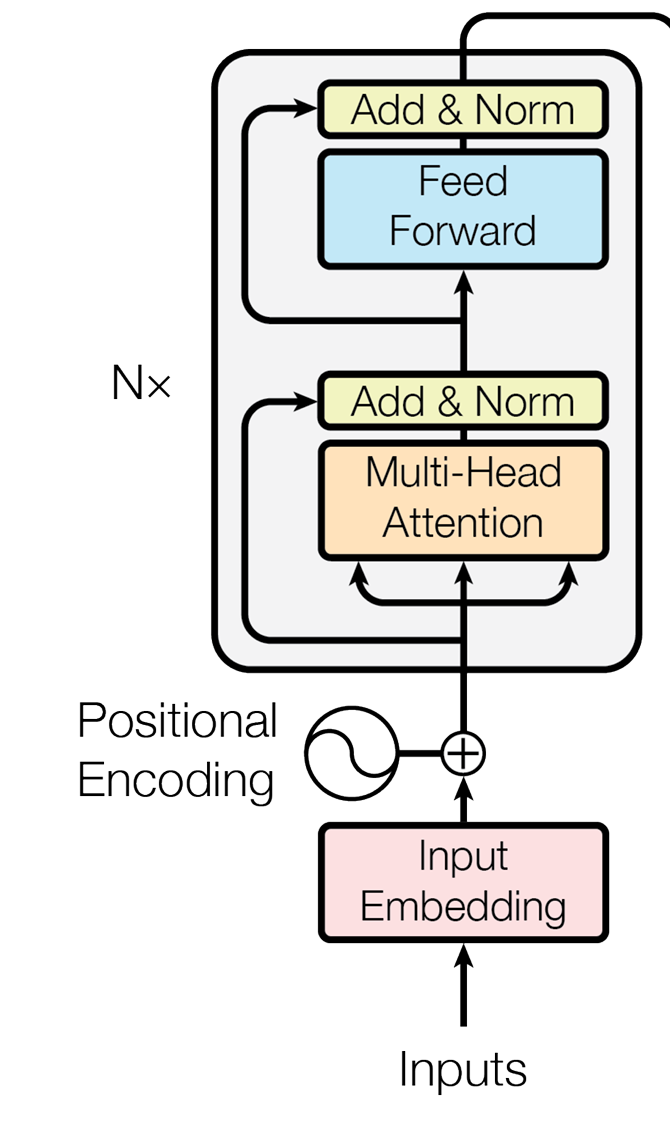

In [14]:
from IPython.display import Image
Image("img/encoder.PNG")

In `encoder.py`, you will need to complete the `def forward(self, x,self_attn_padding_mask = None)` defined in the class `class TransformerEncoderLayer(nn.Module)`, which implements a single layer in the Transformer encoder. In `def __init__(self, embedding_dim, ffn_embedding_dim, num_attention_heads, dropout_prob)`, we have already pre-defined some model submodules and hyperparameters as:

    self.embedding_dim - This is the model dimension, aka d_model

    self.self_attn  - Build the self-attention mechanism using MultiHeadAttention implemented earlier
    
    self.self_attn_layer_norm - Layer norm for the self-attention layer's output
    
    self.activation_fn - The ReLU activation for position-wise feed-forward network
    
    self.fc1 - The parameters will be used for W_1 and b_1 in the position-wise feed-forward network
    
    self.fc2 - The parameters will be used for W_2 and b_2 in the position-wise feed-forward network

    self.dropout - The DropOut regularization module to be applied immediately after self-attention module and FFN module

As described earlier, in `def forward(self, x,self_attn_padding_mask = None)`, you are simply asked to implement:
$$\operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{Self-Attention}(x)))$$
followed by
$$\operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{FFN}(x)))$$
where $\operatorname{FFN}(x)=\max \left(0, x W_1+b_1\right) W_2+b_2$.

You should use all the model parameters already given to you in `class TransformerEncoderLayer(nn.Module)`, and should not need to define or use other parameters or helper functions.

The entire Transformer encoder has already been implemented for you, which simply stacks the Transformer Encoder Layer implemented earlier together to form a Transformer Encoder. Please read the `class TransformerEncoder(nn.Module)` in `encoder.py` as you will need to invoke its `forward` function later.

In [2]:
from encoder import TransformerEncoder, TransformerEncoderLayer
help(TransformerEncoderLayer.forward)

Help on function forward in module encoder:

forward(self, x, self_attn_padding_mask=None)
    Applies the self attention module + Dropout + Add & Norm operation, and the position-wise feedforward network + Dropout + Add & Norm operation. Note that LayerNorm is applied after the self-attention, and another time after the ffn modules, similar to the original Transformer implementation.
    
    Input:
        x (torch.Tensor) - input tensor of size B x T x embedding_dim from the encoder input or the previous encoder layer; serves as input to the TransformerEncoderLayer's self attention mechanism.
    
        self_attn_padding_mask (None/torch.Tensor) - If it is not None, then it is a torch.IntTensor/torch.LongTensor of size B x T, where for each self_attn_padding_mask[b] for the b-th source in the batch, the non-zero positions will be ignored as they represent the padded region during batchify operation in the dataloader (i.e., disallowed for attention) while the zero positions will be

To finish your Transformer encoder (after reading the implementation in `class TransformerEncoder(nn.Module)`), you now need to implement the `def forward_encoder(self, src, src_lengths)` in `class Transformer(nn.Module)`, which is defined in `transformer.py`. The 
`__init__(self, src_vocab_size, tgt_vocab_size, sos_idx, eos_idx, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout_prob)` defines some model submodules and hyperparameters that are related to `forward_encoder` as:

    self.encoder_embedding - Encoder input embedding that converts discrete tokens into continuous vectors; this will be already invoked for you in forward_encoder to get the encoder's input src_embedded.
    
    self.positional_encoding - Positional Encoding used by the Transformer encoder; this will be already invoked for you in forward_encoder to get the encoder's input src_embedded.
    
    self.encoder - Creates an instance of TransformerEncoder.
    
    self.dropout - For applying additional dropout after positional encoding; this will be already invoked for you in forward_encoder to get the encoder's input src_embedded.

All you need to do in `def forward_encoder(self, src, src_lengths)` is to create the padding mask for the encoder input correctly, and get the output from the `TransformerEncoder` correctly. You will find the helper function `def length_to_padding_mask(lengths, device="cpu", dtype=torch.long)` to be useful for creating the padding mask (aka `encoder_padding_mask`, or `self_attn_padding_mask`). 

In [8]:
help(TransformerEncoder.forward)

Help on function forward in module encoder:

forward(self, x, encoder_padding_mask=None)
    Applies the encoder layers in self.layers one by one, followed by an optional output layer if it exists
    
    Input:
        x (torch.Tensor) - input tensor of size B x T x embedding_dim; input to the TransformerEncoderLayer's self attention mechanism
    
        encoder_padding_mask (None/torch.Tensor) - If it is not None, then it is a torch.IntTensor/torch.LongTensor of size B x T, where for each encoder_padding_mask[b] for the b-th source in the batch, the non-zero positions will be ignored as they represent the padded region during batchify operation in the dataloader (i.e., disallowed for attention) while the zero positions will be allowed for attention as they are within the length of the original sequence
    
    Output:
        x (torch.Tensor) - the Transformer encoder's output, of size B x T x embedding_dim, if output layer is None, or of size B x T x output_layer_size, if there 

In [3]:
from transformer import Transformer, length_to_padding_mask
help(Transformer.forward_encoder)

Help on function forward_encoder in module transformer:

forward_encoder(self, src, src_lengths)
    Applies the Transformer encoder to src, where each sequence in src has been padded to the max(src_lengths)
    
    Input:
        src (torch.Tensor) - Encoder's input tensor of size B x T_e x d_model
    
        src_lengths (torch.Tensor) - A 1D iterable of Long/Int of length B, where the b-th length in src_lengths corresponds to the actual length of src[b] (beyond that is the pre-padded region); T_e = max(src_lengths)
    
    Output:
        enc_output (torch.Tensor) - the Transformer encoder's output, of size B x T_e x d_model
    
        src_padding_mask (torch.Tensor) - the encoder_padding_mask/key_padding_mask used by the Transformer encoder's self-attention; this should be created from src_lengths



In [11]:
help(length_to_padding_mask)

Help on function length_to_padding_mask in module transformer:

length_to_padding_mask(lengths, device='cpu', dtype=torch.int64)
    Convert a list/1D tensor/1D array of length in to padding masks used by the encoder and the decoder's attention mechanism
    
    For example, length_to_padding_mask([3, 4, 5]) will return a torch.tensor of dtype, on the device, as:
    [[0, 0, 0, 1, 1],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0]]
    
    Input:
        lengths (List/torch.Tensor/np.array) - a 1D iterable List/torch.Tensor/np.array 
        device (str/torch.Tensor.device): where the return tensor will be located, say, "cpu" or "cuda" or torch.Tensor.device
        dtype (torch.dtype) - result dtype
    
    Output:
        ret (torch.Tensor) - a padding mask of size len(lengths) x max(lengths), with non-zero positions indicating locations out of bounds , of "dtype", on the "device"



If you believe you have implemented everything in this section correctly, you can run `python.grade.py` to see if you have passed the test related to the Transformer encoder implementation, assuming ALL your previous tests have passed. We have defined one test for checking your Transformer encoder implementation that you should have passed: `test_encoder_output`, which initializes a `Transformer` object, loads the model weights from a de-en neural machine translation checkpoint `trained_de_en_state_dict.pt`, and invokes the `forward_encoder` function on some German sentences (that are converted to discrete index sequences) to check against the intermediate encoder output pre-generated by our implementation.

It is expected, for now, for the other four tests to either fail or error out (assuming you passed the four tests for `mha.py`, and the one test for `pe.py` already)

Note: if you are getting a very small error that causes you to fail the test, please double-check that you have the correct torch version installed. Our outputs on the visible set are pre-generated using `Python 3.10` and `torch== 2.0.1`, so at the very least you need to make sure that you are using `torch==2.0.1` for this. It has been known that newer or older PyTorch versions may have slightly different implementations of the same internal module, and result in slightly different computed results. If in doubt, you can also submit to GradeScope for testing. The auto-grader on GradeScope will NOT have this issue, as the solutions will be generated during the submission with the same platform and package versions as your implementation will use, but your code will be tested on the hidden set instead.

In [29]:
!python grade.py

EE......EE
ERROR: test_encoder_decoder_predictions (test_visible.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\tests\test_visible.py", line 311, in test_encoder_decoder_predictions
    output = model(src = src, tgt = trg, src_lengths = src_lengths, tgt_lengths = trg_lengths)
  File "C:\Users\leebo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 230, in forward
    dec_output = self.forward_decoder(enc_output, src_padding_mask, tgt, tgt_lengths)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 205, in forward_decoder
    return dec_output
NameError: name 'de

## Transformer Decoder <a id="chapter4"></a>

The Transformer Decoder consists of a stack of Transformer decoder layers. Each decoder layer has three sets of sub-layer operations, applied one set after another. The first set involves the decoder multi-head self-attention mechanism, the second set involves multi-head encoder-decoder attention mechanism, and the third set involves a simple, position-wise, fully connected feed-forward network. A dropout operation is immediately applied to the output of the sub-layer, followed by a residual connection around each of the two sub-layers, followed by layer normalization. That is, let $x$ denote the input to the sub-layer, the output of each sub-layer is $\operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{Sublayer}(x)))$, where $\operatorname{Sublayer}(x)$ is the function implemented by the sub-layer itself.

For the first $\operatorname{Sublayer}(x)$, the decoder multi-head self-attention mechanism, all of the keys, values, and queries come from the same place, and are either the decoder input (for the first layer) or the output of the previous decoder layer (for subsequent layers). However, unlike encoder self-attention, we prevent each temporal position in the temporal dimension from attending to subsequent positions. We have already taken care of this scenario with the `attention_mask` argument in the `forward` function of the `MultiHeadAttention` module. This masking ensures that the predictions for position $i+1$ can depend only on the known outputs at positions up to and including $i$. If we are padding each decoder input in the batch to the same length, we still need to use a mask to additionally avoid the decoder self-attention mechanism from attending to positions beyond the original input length.

For the second $\operatorname{Sublayer}(x)$, the encoder-decoder multi-head attention mechanism, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend to all positions in the input sequence. We still need to use a mask to avoid attending to positions beyond the original input sequence length.

For the third $\operatorname{Sublayer}(x)$, the position-wise, fully-connected feed-forward network, the network is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between, as $\operatorname{FFN}(x)=\max \left(0, x W_1+b_1\right) W_2+b_2$, where for the inner layer, $W_1 \in \mathbb{R}^{d_{model} \times d_{ff}}$, $b_1 \in \mathbb{R}^{d_{ff}}$ and for the outer layer, $W_2 \in \mathbb{R}^{d_{ff} \times d_{model}}$, $b_2 \in \mathbb{R}^{d_{model}}$. 

The figure below from pg. 3 of the original paper shows the entire Transformer encoder-decoder architecture, as part of the encoder-decoder attention module's input comes from the Transformer encoder.

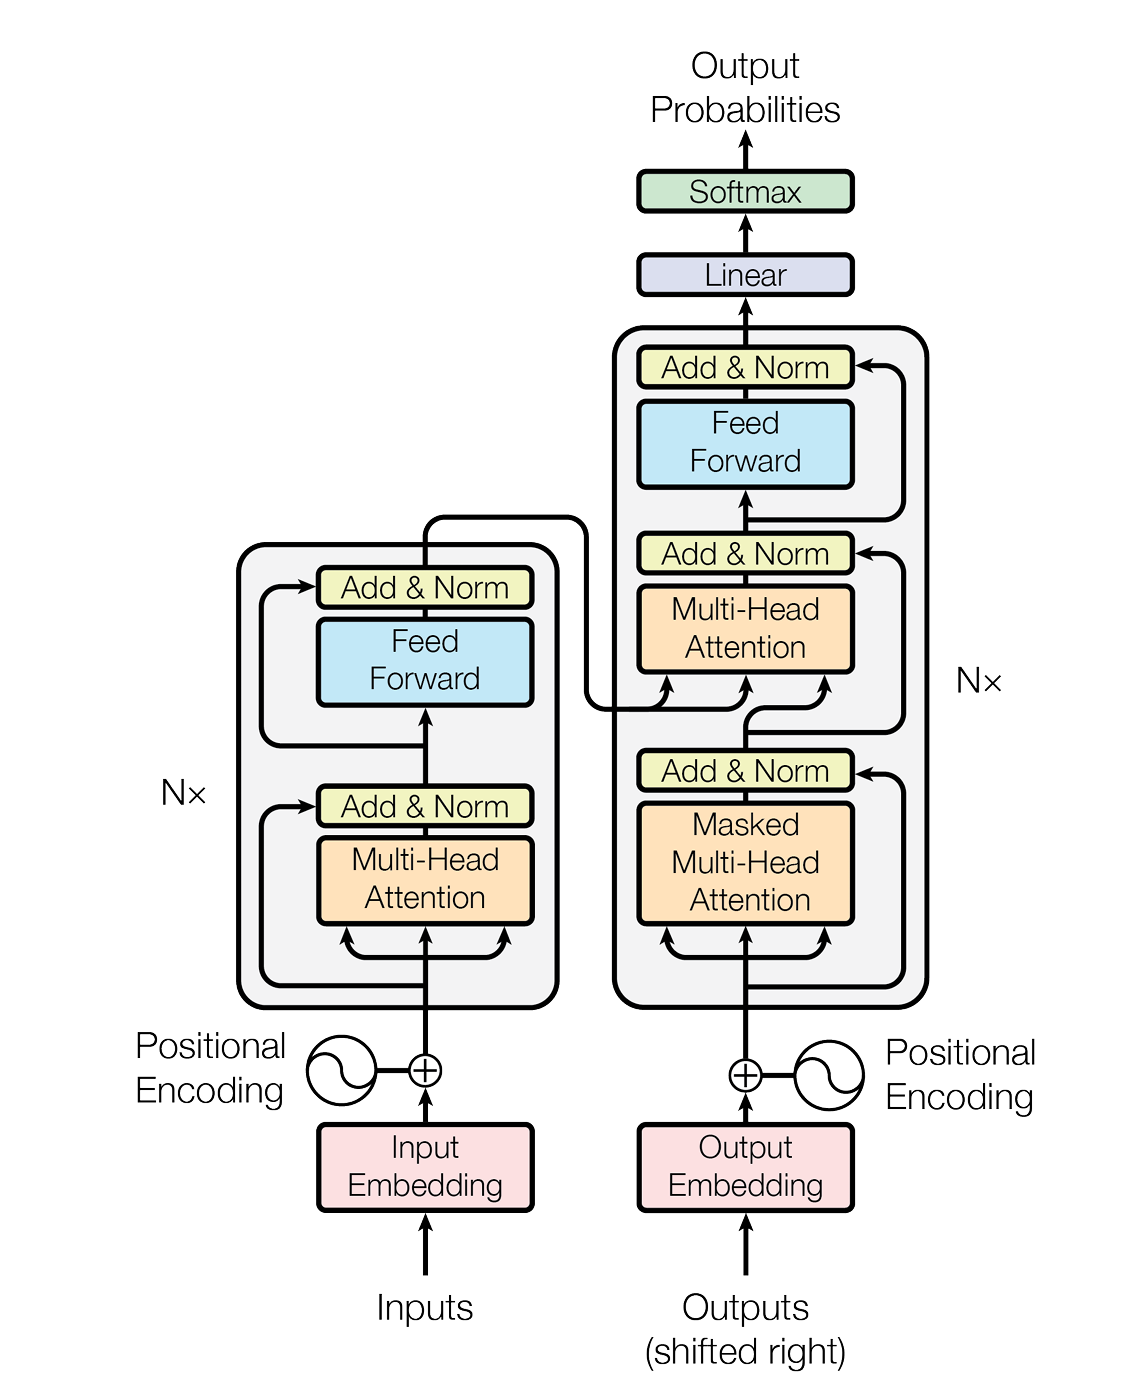

In [15]:
from IPython.display import Image
Image("img/encoder_decoder.PNG")

In `decoder.py`, you will need to complete the `def forward(self, x, encoder_out = None, encoder_padding_mask = None, self_attn_padding_mask = None,self_attn_mask = None)` defined in the class `class TransformerDecoderLayer(nn.Module)`, which implements a single decoder layer in the Transformer decoder. In `def __init__(self, embedding_dim, ffn_embedding_dim, num_attention_heads, dropout_prob, no_encoder_attn=False)`, we have already pre-defined some model submodules and hyperparameters as:

    self.embedding_dim - This is the model dimension, aka d_model

    self.self_attn  - Build the decoder self-attention mechanism using MultiHeadAttention implemented earlier
    
    self.self_attn_layer_norm - Layer norm for the decoder self-attention layer's output

    self.encoder_attn - If an encoder-decoder architecture is built, we build the encoder-decoder attention using MultiHeadAttention implemented earlier
    
    self.encoder_attn_layer_norm - Layer norm for the encoder-decoder attention layer's output
    
    self.activation_fn - The ReLU activation for position-wise feed-forward network
    
    self.fc1 - The parameters will be used for W_1 and b_1 in the position-wise feed-forward network
    
    self.fc2 - The parameters will be used for W_2 and b_2 in the position-wise feed-forward network

    self.dropout - The DropOut regularization module to be applied immediately after self-attention module, encoder-decoder attention module and FFN module

As described earlier, in `def forward(self, x, encoder_out = None, encoder_padding_mask = None, self_attn_padding_mask = None,self_attn_mask = None)`, you are simply asked to implement:
$$ x = \operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{Decoder-Self-Attention}(x)))$$
followed by
$$ x = \operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{Encoder-Decoder-Attention}(x, encoder\_out)))$$
followed by
$$ x = \operatorname{LayerNorm}(x + \operatorname{DropOut}(\operatorname{FFN}(x)))$$
where $\operatorname{FFN}(x)=\max \left(0, x W_1+b_1\right) W_2+b_2$.

You should use all the model parameters already given to you in `class TransformerDecoderLayer(nn.Module)`, and should not need to define or use other parameters or helper functions.

The entire Transformer decoder has already been implemented for you, which simply stacks the TransformerDecoderLayer implemented earlier together to form a TransformerDecoder. Please read the `class TransformerDecoder(nn.Module)` in `decoder.py` as you will need to invoke its `forward` function later.

In [4]:
from decoder import TransformerDecoder, TransformerDecoderLayer
help(TransformerDecoderLayer.forward)

Help on function forward in module decoder:

forward(self, x, encoder_out=None, encoder_padding_mask=None, self_attn_padding_mask=None, self_attn_mask=None)
    Applies the self attention module + Dropout + Add & Norm operation, the encoder-decoder attention + Dropout + Add & Norm operation (if self.encoder_attn is not None), and the position-wise feedforward network + Dropout + Add & Norm operation. Note that LayerNorm is applied after the self-attention operation, after the encoder-decoder attention operation and another time after the ffn modules, similar to the original Transformer implementation.
    
    Input:
        x (torch.Tensor) - input tensor of size B x T_d x embedding_dim from the decoder input or the previous encoder layer, where T_d is the decoder's temporal dimension; serves as input to the TransformerDecoderLayer's self attention mechanism.
    
        encoder_out (None/torch.Tensor) - If it is not None, then it is the output from the TransformerEncoder as a tensor

To finish your Transformer decoder (after reading the implementation in `class TransformerDecoder(nn.Module)`), you now need to implement the `def forward_decoder(self, enc_output, src_padding_mask, tgt, tgt_lengths)` in `class Transformer(nn.Module)`, which is defined in `transformer.py`. The 
`__init__(self, src_vocab_size, tgt_vocab_size, sos_idx, eos_idx, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout_prob)` defines some model submodules and hyperparameters that are related to `forward_decoder` as:

    self.decoder_embedding - Decoder input embedding that converts discrete tokens into continuous vectors; this will be already invoked for you in forward_decoder to get the decoder's input tgt_embedded.
    
    self.positional_encoding - Positional Encoding used by the Transformer decoder; this will be already invoked for you in forward_decoder to get the decoder's input tgt_embedded.
    
    self.decoder - Creates an instance of TransformerDecoder.
    
    self.dropout - For applying additional dropout after positional encoding; this will be already invoked for you in forward_decoder to get the decoder's input tgt_embedded.

    self.sos_idx - Every encoder and decoder sequence starts with this token index (useful in extra-credit)
    self.eos_idx - Every encoder and decoder sequence ends with this token index (useful in extra-credit)

All you need to do in `def forward_decoder(self, enc_output, src_padding_mask, tgt, tgt_lengths)` is to a. create the padding mask and the attention mask for the decoder input correctly; b. pass the `tgt_embedded`, which is your decoder (target) sequence input, `enc_output` and `src_padding_mask`, which are return values from your `forward_encoder`, into the `forward` call of `TransformerDecoder` object; c. return the decoder output.

You will find the helper function `def length_to_padding_mask(lengths, device="cpu", dtype=torch.long)` to be useful for creating the padding mask for padded decoder input (aka `self_attn_padding_mask`). You will find the helper function `def subsequent_mask(size, device="cpu", dtype=torch.long)` to be useful for creating the additional decoder auto-regressive mask for self-attention (aka `self_attn_mask`). 

In [18]:
help(TransformerDecoder.forward)

Help on function forward in module decoder:

forward(self, x, decoder_padding_mask=None, decoder_attention_mask=None, encoder_out=None, encoder_padding_mask=None)
    Applies the encoder layers in self.layers one by one, followed by an optional output layer if it exists
    
    Input:
        x (torch.Tensor) - input tensor of size B x T_d x embedding_dim; input to the TransformerDecoderLayer's self attention mechanism
    
        decoder_padding_mask (None/torch.Tensor) - If it is not None, then it is a torch.IntTensor/torch.LongTensor of size B x T_d, where for each decoder_padding_mask[b] for the b-th source in the batched tensor x[b], the non-zero positions will be ignored as they represent the padded region during batchify operation in the dataloader (i.e., disallowed for attention) while the zero positions will be allowed for attention as they are within the length of the original sequence
    
        decoder_attention_mask (None/torch.Tensor) - If it is not None, then it is a

In [19]:
help(Transformer.forward_decoder)

Help on function forward_decoder in module transformer:

forward_decoder(self, enc_output, src_padding_mask, tgt, tgt_lengths)
    Applies the Transformer decoder to tgt and enc_output (possibly as used during training to obtain the next token prediction under teacher-forcing), where sequences in enc_output are associated with src_padding_mask, and each sequence in tgt has been padded to the max(tgt_lengths)
    
    Input:
        enc_output (torch.Tensor) - the Transformer encoder's output, of size B x T_e x d_model
    
        src_padding_mask (torch.Tensor) - the encoder_padding_mask/key_padding_mask associated with enc_output. It is a torch.IntTensor/torch.LongTensor of size B x T_e, where for each src_padding_mask[b] for the b-th source in the batched tensor enc_output[b], the non-zero positions will be ignored as they represent the padded region during batchify operation in the dataloader (i.e., disallowed for attention) while the zero positions will be allowed for attention as

In [5]:
from transformer import subsequent_mask
help(subsequent_mask)

Help on function subsequent_mask in module transformer:

subsequent_mask(size, device='cpu', dtype=torch.int64)
    Create mask for subsequent steps size x size; this may be useful for creating decoder attention masks for parallel auto-regressive training.
    
    subsequent_mask(3) will return a torch.tensor of dtype, on the device, as:
    [[0, 1, 1],
     [0, 0, 1],
     [0, 0, 0]]
    
    Input:
        size (int) - size of mask
        device (str/torch.Tensor.device): where the return tensor will be located, say, "cpu" or "cuda" or torch.Tensor.device
        dtype (torch.dtype) - result dtype
    
    Output:
        torch.Tensor - mask for subsequent steps with shape as size x size, of "dtype", on the "device"



If you believe you have implemented everything in this section correctly, you can run `python.grade.py` to see if you have passed the test related to the Transformer decoder implementation, assuming ALL your previous tests have passed. We have defined two tests that you should have passed: `test_encoder_decoder_predictions`, which initializes a `Transformer` object, loads the model weights from a de-en neural machine translation checkpoint `trained_de_en_state_dict.pt`, and invokes the `forward_decoder` function on some German sentences (that are converted to discrete index sequences), which, conditioned on previous tokens in the parallel English sentences, predicts the next tokens in English. We take your next token prediction outputs of the unpadded regions to check against the next token predictions pre-generated by our implementation. This test will also throw an error if the  next token prediction accuracy does not match ours, which indicates some major bugs. The second test, `test_encoder_decoder_states,` works similarly, except that we are checking your pre-softmax output layer states from the decoder instead of discrete predictions.

It is expected, for now, for the other two tests to either fail or error out, as they are for extra credit (assuming you passed the four tests for `mha.py`, the one test for `pe.py`, and the one test for your Transformer encoder implementation).

Note: if you are getting a very small error that causes you to fail the test, please double-check that you have the correct torch version installed. Our outputs on the visible set are pre-generated using `Python 3.10` and `torch== 2.0.1`, so at the very least you need to make sure that you are using `torch==2.0.1` for this. It has been known that newer or older PyTorch versions may have slightly different implementations of the same internal module, and result in slightly different computed results. If in doubt, you can also submit to GradeScope for testing. The auto-grader on GradeScope will NOT have this issue, as the solutions will be generated during the submission with the same platform and package versions as your implementation will use, but your code will be tested on the hidden set instead.

In [10]:
!python grade.py

.F......EE
ERROR: test_decoder_inference_cache_extra_credit (test_visible_ec.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\tests\test_visible_ec.py", line 162, in test_decoder_inference_cache_extra_credit
    output_list, decoder_cache = model.inference(src = src, src_lengths = src_lengths, max_output_length = MAX_INFERENCE_LENGTH)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 266, in inference
    tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
NameError: name 'tgt' is not defined

ERROR: test_decoder_inference_outputs_extra_credit (test_visible_ec.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\tests\test_visible_ec.py", line 109, in test_d

## Submission

For submission onto GradeScope, make sure you are uploading all relevant Python modules onto Gradescope. Again, these are:
```
mha.py
pe.py
encoder.py
decoder.py
transformer.py
```

## Extra Credit: Auto-regressive Decoding During Inference <a id="chapter5"></a>

In the main part of the MP, we implemented the `forward` function of the Transformer decoder. The previous implementation is mainly used in training. During training, when we are given paired source and target sequences, we feed the source sequence into the encoder, we feed the entire target sequence as the decoder's input, and we predict the left-shifted target sequence with the decoder auto-regressive attention mask applied (conditioned on the encoder's output). Hence, we call this training routine "teacher-forcing". 

This is depicted in the following figure, where we use $[x_1, x_2, x_3, x_4]$ to indicate the source sequence and $[y_1, y_2, y_3]$ to indicate the paired target sequence, as one would find in most sequence-to-sequence parallel datasets. We introduce the $<sos>$ token as the start-of-sentence sentinel and the $<eos>$ token as the end-of-sentence sentinel. Note that with our decoder auto-regressive attention mask implemented earlier (and passed to the decoder during training), when predicting $y_1$, besides the entire encoder states $[\bar{x}_1, \bar{x}_2, \bar{x}_3, \bar{x}_4]$, it can only access the decoder states of $<sos>$ for decoder self-attention; when predicting $y_2$, besides the entire encoder states $[\bar{x}_1, \bar{x}_2, \bar{x}_3, \bar{x}_4]$,  it can only access the decoder states of $<sos>$ and $y_1$ for decoder self-attention; when predicting $y_3$, besides the entire encoder states $[\bar{x}_1, \bar{x}_2, \bar{x}_3, \bar{x}_4]$, it can only access the decoder states of $<sos>$, $y_1$ and $y_2$ for decoder self-attention; when predicting $<eos>$, besides the entire encoder states $[\bar{x}_1, \bar{x}_2, \bar{x}_3, \bar{x}_4]$,  it can access the decoder states of $<sos>$ , $y_1$, $y_2$ and $y_3$ for decoder self-attention. 

Note that even if the decoder were to make a mistake after the output layer during training, and suppose that it predicts $y_2$ as $\tilde{y}_2$, when predicting $y_3$, the decoder prediction is still conditioned on the decoder states generated by $<sos>$, $y_1$ and $y_2$, instead of $<sos>$, $y_1$ and $\tilde{y}_2$. This is where the name "teacher-forcing" came from.

In [25]:
from IPython.display import SVG
SVG("img/encoder_decoder_teacher_forcing.SVG")

After training the encoder-decoder model, one shall use it for inference by providing the model with just the source sequence $[x_1, x_2, x_3, x_4]$. Now we must put the decoder in the truly auto-regressive mode. To do so, the decoder must work in a step-by-step fashion, by conditioning the prediction for time step $T+1$ on the predicted tokens from $t=1, 2,\cdots, T$ as:
```
 enc_out = Encoder([x_1,..., x_H])

 y_hat = [sos]
 
 While the last token of y_hat is not eos:
 
     y_hat_i =  Decoder(y_hat, enc_out)
     
     Append y_hat_i to the end of y_hat

 return y_hat
```
     
which is depicted by the following figure.

In [26]:
from IPython.display import SVG
SVG("img/encoder_decoder_inference.SVG")

To complete the extra credit, you will need to complete the missing code in three functions.

The first function is `def forward_one_step_ec(self, x, encoder_out = None, encoder_padding_mask = None, self_attn_padding_mask = None, self_attn_mask = None, cache = None)` in `class TransformerDecoderLayer(nn.Module)`, within `decoder.py`. Please read the function helper and the comments within.

In [29]:
help(TransformerDecoderLayer.forward_one_step_ec)

Help on function forward_one_step_ec in module decoder:

forward_one_step_ec(self, x, encoder_out=None, encoder_padding_mask=None, self_attn_padding_mask=None, self_attn_mask=None, cache=None)
    Applies the self attention module + Dropout + Add & Norm operation, the encoder-decoder attention + Dropout + Add & Norm operation (if self.encoder_attn is not None), and the position-wise feedforward network + Dropout + Add & Norm operation, but for just a single time step at the last time step. Note that LayerNorm is applied after the self-attention operation, after the encoder-decoder attention operation and another time after the ffn modules, similar to the original Transformer implementation.
    
    Input:
        x (torch.Tensor) - input tensor of size B x T_d x embedding_dim from the decoder input or the previous encoder layer, where T_d is the decoder's temporal dimension; serves as input to the TransformerDecoderLayer's self attention mechanism. You need to correctly slice x in the

It is very similar to the `forward(self, x, encoder_out=None, encoder_padding_mask=None, self_attn_padding_mask=None, self_attn_mask=None)` in `class TransformerDecoderLayer(nn.Module)`, except for a few things:
1. While `x` is still an input tensor of size (B, T_d, embedding_dim), when calculating the decoder self-attention, you need to slice the input `x` and the input masks so that the last frame `ag_x` of shape (B , 1 ,embedding_dim) shall attend to all temporal dimensions of `x`, and the output of decoder self-attention, encoder-decoder attention, and position-wise feedforward network are all of the shape (B , 1 ,embedding_dim).
1. It has an extra input argument called `cache`. This is the decoder layer output for the current decoder layer computed until and including the previous time step. Hence, the temporal dimension is one less than the temporal dimension of the decoder input argument `x`. Once you have computed the layer output of the current time step, you need to concatenate your computed one-frame-length output of size (B , 1 ,embedding_dim) to the temporal dimension of `cache`, and return it as the return value. 

The second function you need to write is `def forward_one_step_ec(self, x, decoder_padding_mask = None, decoder_attention_mask = None, encoder_out = None, encoder_padding_mask = None, cache = None)` in `class TransformerDecoder(nn.Module)`, within `decoder.py`. Please read the function helper and the comments within.

In [38]:
import decoder
import importlib
importlib.reload(decoder)
help(decoder.TransformerDecoder.forward_one_step_ec)

Help on function forward_one_step_ec in module decoder:

forward_one_step_ec(self, x, decoder_padding_mask=None, decoder_attention_mask=None, encoder_out=None, encoder_padding_mask=None, cache=None)
    Forward one step.
    
    Input:
        x (torch.Tensor) - input tensor of size B x T_d x embedding_dim; input to the TransformerDecoderLayer's self attention mechanism
    
        decoder_padding_mask (None/torch.Tensor) - If it is not None, then it is a torch.IntTensor/torch.LongTensor of size B x T_d, where for each decoder_padding_mask[b] for the b-th source in the batched tensor x[b], the non-zero positions will be ignored as they represent the padded region during batchify operation in the dataloader (i.e., disallowed for attention) while the zero positions will be allowed for attention as they are within the length of the original sequence
    
        decoder_attention_mask (None/torch.Tensor) - If it is not None, then it is a torch.IntTensor/torch.LongTensor of size 1 x T_d 

It is very similar to `forward(self, x, decoder_padding_mask = None, decoder_attention_mask = None, encoder_out = None, encoder_padding_mask = None)` in `class TransformerDecoder(nn.Module)`, except for a few things:
1. Instead of calling into the `forward` function of `TransformerDecoderLayer`, you need to call into the `forward_one_step_ec` that you just completed for `TransformerDecoderLayer`.
1. The output of this function is a tuple `(y, new_cache)`. `y` is a single output frame in the temporal dimension. To correctly return `new_cache,` you need to store a list of layer outputs of (B, T_d, embedding_dim) as returned by each decoder layer separately so that this `new_cache` can be used by the function caller (immediately described below) for auto-regressive decoding the next time step (and, of course, the `new_cache` returned by this next call into `forward_one_step_ec` for the next time step would be (B, T_d + 1, embedding_dim))

The last function you need to complete is `def inference(self, src, src_lengths, max_output_length)` in `class Transformer(nn.Module)`, within `transformer.py`. Most of the function has been completed for you. The only things you need to figure out is to initialize `tgt`, the starting decoder input sequence, to extend your decoder predictions, and when to break out of the decoding loop. We assume that every output sequence starts with `self.sos` and end with `self.eos`. Please refer to the figure and the pseudo-code for auto-regressive inference at the start of this section.

In [39]:
help(Transformer.inference)

Help on function inference in module transformer:

inference(self, src, src_lengths, max_output_length)
    Applies the entire Transformer encoder-decoder to src and target, possibly as used during inference to auto-regressively obtain the next token; each sequence in src has been padded to the max(src_lengths)
    Input:
        src (torch.Tensor) - Encoder's input tensor of size B x T_e x d_model
    
        src_lengths (torch.Tensor) - A 1D iterable of Long/Int of length B, where the b-th length in src_lengths corresponds to the actual length of src[b] (beyond that is the pre-padded region); T_e = max(src_lengths)
    
        
    Output:
        decoded_list (List(torch.Tensor) - a list of auto-regressively obtained decoder output token predictions; the b-th item of the decoded_list should be the output from src[b], and each of the sequence predictions in decoded_list is of a possibly different length. 
    
        decoder_layer_cache_list (List(List(torch.Tensor))) - a list of 

If you believe you have implemented everything in this section correctly, you can run `python.grade.py` to see if you have passed the test related to the extra credit auto-regressive inference implementation, assuming ALL your previous tests have passed. We have defined two tests that you should have passed: `test_decoder_inference_outputs_extra_credit`, which initializes a `Transformer` object, loads the model weights from a de-en neural machine translation checkpoint `trained_de_en_state_dict.pt`, and invokes the `inference` function on some German sentences (that are converted to discrete index sequences), which auto-regressively decodes the English translation (that are in the form of discrete index sequences). We take your `decoded_list` returned by `inference` to check against our decoded results pre-generated by our implementation. This test will also throw an error if the normalized edit distance, or error rate computed against ground-truth English translations, does not match ours, which indicates some major bugs. The second test, `test_decoder_inference_cache_extra_credit,` works similarly, except that we are checking the `decoder_layer_cache_list` returned by `inference` function, which is a more careful examination of whether your auto-regressive inference has been implemented correctly.

Note: if you are getting a very small error that causes you to fail the test, please double-check that you have the correct torch version installed. Our outputs on the visible set are pre-generated using `Python 3.10` and `torch== 2.0.1`, so at the very least you need to make sure that you are using `torch==2.0.1` for this. It has been known that newer or older PyTorch versions may have slightly different implementations of the same internal module, and result in slightly different computed results. If in doubt, you can also submit to GradeScope for testing. The auto-grader on GradeScope will NOT have this issue, as the solutions will be generated during the submission with the same platform and package versions as your implementation will use, but your code will be tested on the hidden set instead.

In [2]:
!python grade.py

torch.Size([10, 19, 19]) torch.Size([10, 18])
torch.Size([10, 19, 19]) torch.Size([10, 18])


EE......EE
ERROR: test_encoder_decoder_predictions (test_visible.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\tests\test_visible.py", line 311, in test_encoder_decoder_predictions
    output = model(src = src, tgt = trg, src_lengths = src_lengths, tgt_lengths = trg_lengths)
  File "C:\Users\leebo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 225, in forward
    dec_output = self.forward_decoder(enc_output, src_padding_mask, tgt, tgt_lengths)
  File "c:\Users\leebo\OneDrive\桌面\Artificial Intelligence\MP\mp09\transformer.py", line 196, in forward_decoder
    dec_output = self.decoder(tgt_embedde